# Load Data (Similar to Andy's Notebook)

In [1]:
import os, sys
from pathlib import Path
import urllib.request
from collections import Counter, defaultdict
import string
import re
from importlib import reload
import math
import datetime

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline

import models.fasttext as fasttext
import models.cnn as cnn
reload(fasttext)
reload(cnn);

In [2]:
tv_show = "friends"

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

root_path = Path().resolve().joinpath("..")
show_data_path = root_path.joinpath("scrape", "data", tv_show, "parsed")
embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
print(embeddings_path)

/home/jovyan/work/analysis/../embeddings/newscrawl.300d.W.pos.vectors.gz


In [7]:
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

!gunzip {str(embeddings_path)} 

downloading embeddings...


## Load the training data

In [8]:
dialog_datas = []

for filename in os.listdir(show_data_path):
    dialog_data = pd.read_csv(show_data_path.joinpath(filename), header=None, names=("speaker", "utterance"))
    dialog_data["episode"] = filename.split(".")[0]
    dialog_datas.append(dialog_data)
    
all_dialog_data = pd.concat(dialog_datas).dropna().reset_index(drop=True)

In [9]:
print(all_dialog_data.count())
all_dialog_data.head()

speaker      55025
utterance    55025
episode      55025
dtype: int64


,speaker,utterance,episode
0,Phoebe,"Oh, hey Joey.",1012
1,Joey,"Uh, hey.",1012
2,Phoebe,"Listen, I need to ask you something. Ok, you k...",1012
3,Joey,Yeah.,1012
4,Phoebe,"Yeah. Well, uhm... listen he was supposed to g...",1012


## Data Pre-processing and Minor Analysis (Just to make sure it's the same as Andy's)

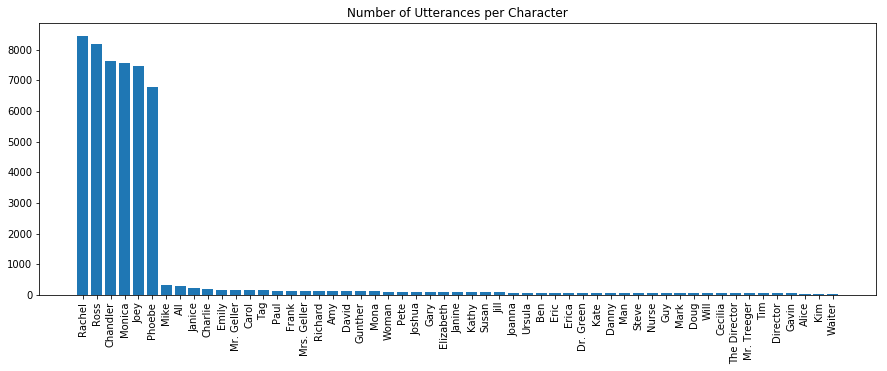

In [10]:
speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(111)
sub.bar(x, y)
for tick in sub.get_xticklabels():
    tick.set_rotation(90)
plt.title("Number of Utterances per Character")
plt.show()

In [11]:
num_major_characters = 6
major_characters = x[:num_major_characters]
major_characters_set = set(major_characters)

In [12]:
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

In [13]:
major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(major_characters_set)]
print(major_dialog_data.count())

speaker      46079
utterance    46079
episode      46079
dtype: int64


In [14]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

labels = major_dialog_data.speaker

#utterances = list(map(lambda utter: tokenizer.tokenize(utter.lower()), major_dialog_data.utterance))
utterances = [tokenizer.tokenize(utter.lower()) for utter in major_dialog_data.utterance]
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

In [15]:
#utterances[10]

#embeddings.type
# Every row of "utterances" returns a list of rows used in the phrase

Text(0.5,1,'Histogram of Utterance lengths')

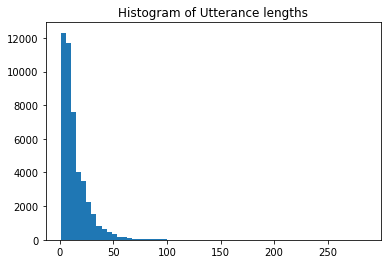

In [16]:
plt.hist([len(words) for words in utterances], bins=60)
plt.title("Histogram of Utterance lengths")

## Baseline Model - Always predict most common class (still copying Andy)

In [17]:
np.mean(labels == major_characters[0])

0.18329390828794029

In [18]:
def shuffle(x, y):
    m = x.shape[0]
    rand_perm = np.random.permutation(m)
    x = x[rand_perm]
    y = y[rand_perm]
    return x, y

def batch_iter(x, y, batch_size):
    num_batches = int(np.ceil(x.shape[0] / batch_size))
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        yield i, x[start:end], y[start:end]

In [19]:
non_empty_utterances = []
non_empty_utterance_labels = []

# Every row of "utterances" returns a list of rows used in the phrase

# For every "phrase" within the dataset
for i, utterance in enumerate(utterances):
    # Filter out words that are not stop words and are in the embeddings vocab
    words = [word for word in utterance if word in embeddings.vocab and word not in stop_words]
    
    # Add nonempty phrases afterward into another list called "non_empty_utterances" and "non_empty_utterance_labels"
    if len(words) > 0:
        non_empty_utterances.append(words)
        non_empty_utterance_labels.append(labels.iloc[i])

# Create a dataset "bags" that will be the sum/mean of the embeddings
bags = np.zeros((len(non_empty_utterances), embeddings.vector_size))

for i, utterance in enumerate(non_empty_utterances):
    # Check again if word isn't in the embeddings vocab
    words = [word for word in utterance if word in embeddings.vocab]
    # Create a vectors matrix that would represent the "embedding" layer
    vectors = np.zeros((len(words), embeddings.vector_size))
    for j, word in enumerate(words):
        vectors[j, :] = embeddings.word_vec(word)
    # Sum/mean the embedding layer from the phrase
    bag = np.sum(vectors, axis=0)
    # Add to the bags matrix
    bags[i, :] = bag

# Cut the matrix into training and test dataset by 0.85 cutoff
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
train_x = bags[0:train_cut]
train_y = non_empty_utterance_labels[0:train_cut]
test_x = bags[train_cut:]
test_y = non_empty_utterance_labels[train_cut:]
print(train_x.shape, test_x.shape)

(39168, 300) (4217, 300)


## Alright, now it's time to do some new stuff

In [20]:
train_x[1].shape

(300,)

In [21]:
import models.neuralbow as neuralbow
reload(neuralbow)

<module 'models.neuralbow' from '/home/jovyan/work/analysis/models/neuralbow.py'>

In [22]:
# Specify model hyperparameters as used by model_fn
model_params = dict(V=len(embeddings.vocab), embed_dim=50, hidden_dims=[25], num_classes=num_major_characters,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)

checkpoint_dir = "/tmp/tf_bow_sst_" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
# Write vocabulary to file, so TensorBoard can label embeddings.
# creates checkpoint_dir/projector_config.pbtxt and checkpoint_dir/metadata.tsv
# ds.vocab.write_projector_config(checkpoint_dir, "Encoder/Embedding_Layer/W_embed")

model = tf.estimator.Estimator(model_fn=neuralbow.classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)
print("")
print("To view training (once it starts), run:\n")
print("    tensorboard --logdir='{:s}' --port 6006".format(checkpoint_dir))
print("\nThen in your browser, open: http://localhost:6006")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_bow_sst_20181121-0022', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3d6caaaac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

To view training (once it starts), run:

    tensorboard --logdir='/tmp/tf_bow_sst_20181121-0022' --port 6006

Then in your bro

In [23]:
# Training params, just used in this cell for the input_fn-s
train_params = dict(batch_size=32, total_epochs=20, eval_every=2)
assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

# Construct and train the model, saving checkpoints to the directory above.
# Input function for training set batches
# Do 'eval_every' epochs at once, followed by evaluating on the dev set.
# NOTE: use patch_numpy_io.numpy_input_fn instead of tf.estimator.inputs.numpy_input_fn
train_input_fn = patched_numpy_io.numpy_input_fn(
                    x={"ids": train_x, "ns": train_ns}, y=train_y,
                    batch_size=train_params['batch_size'], 
                    num_epochs=train_params['eval_every'], shuffle=True, seed=42
                 )

# Input function for dev set batches. As above, but:
# - Don't randomize order
# - Iterate exactly once (one epoch)
dev_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": dev_x, "ns": dev_ns}, y=dev_y,
                    batch_size=128, num_epochs=1, shuffle=False
                )

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    # Train for a few epochs, then evaluate on dev
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")

NameError: name 'patched_numpy_io' is not defined